# VGG 16

### 라이브러리 import

In [1]:
# !pip install opencv-python

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import os
import pandas as pd
import cv2 # 이미지 처리를 도와주는 라이브러리
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import json
import h5py
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

## 데이터 로드

In [3]:
# hdf5, json 파일 로드
hdf5_path = os.path.join(os.getcwd(), "data/butterfly_original.hdf5")
json_path = os.path.join(os.getcwd(), "data/butterfly_original_classes.json")

with h5py.File(hdf5_path, 'r') as hf:
    train_data = hf['train_data'][:]
    train_label = hf['train_label'][:]
    test_data = hf['test_data'][:]

with open(json_path, 'r') as j:
    train_classes = json.load(j)

# key값들이 str로 들어오기에 int로 변환해서 다시 저장
train_classes = {int(key):value for key, value in train_classes.items()}

In [4]:
# 이미지 샘플 확인
def imshow(images, labels, classes):
    plt.figure(figsize=(12, 8))

    for i in range(len(images)):
        plt.subplot(1, len(images), i+1)
        plt.imshow(images[i])
        plt.title(classes[labels[i]])
    plt.show()

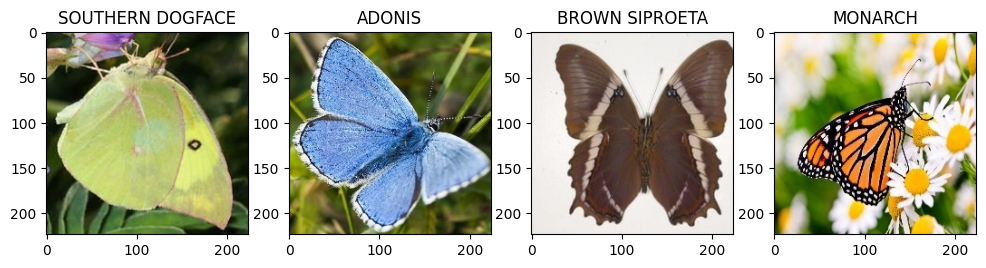

In [5]:
imshow(train_data[:4], train_label[:4], train_classes)

In [6]:
# 데이터셋 생성 클래스
# init: self, image, label, classes, transform, target_transform, test
# len: train - image, label / test - image
# getitem: 정규화
class CustomImageDataset(Dataset):
    def __init__(self, image, label=None, classes=None, transform=None, target_transform=None, test=False):
        self.image = image
        self.label = label
        self.classes = classes
        self.transform = transform
        self.target_transform = target_transform
        self.test = test

    def __len__(self):
        if not(self.test):
            return len(list(zip(self.image, self.label)))
        else:
            return len(list(self.image))
        
    def __getitem__(self, index):
        if not(self.test):
            image = self.image[index]
            label = self.label[index]

            if self.transform:
                image = self.transform(image)
            if self.target_transform:
                label = self.transform(label)

            return image, label
        else:
            image = self.image[index]

            if self.transform:
                image = self.transform(image)

            return image

In [7]:
# 픽셀값들을 정규화 해줌
# 픽셀들은 0~255사이의 값을 가지기 때문에 값들간의 편차가 크다
# 따라서 값들간의 차이를 줄여 가중치의 영향을 줄여주기 위함
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [8]:
# train test dataset 객체 생성
train_dataset = CustomImageDataset(
    image=train_data,
    label=train_label,
    classes=train_classes,
    transform=transform,
    test=False
)

test_dataset = CustomImageDataset(
    image=test_data,
    transform=transform,
    test=True
)

In [9]:
# dataloader 생성
train_dataloader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=True)

### 모델 구현

In [10]:
class VGG_16(nn.Module):
    def __init__(self):
        super(VGG_16,self).__init__()
        self.convnet = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 224 -> 112

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 112 -> 56

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 56 -> 28
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 28 -> 14

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 14 -> 7

            nn.Flatten(), # Flatten은 layer로 안쳐준다.
            nn.Dropout(.5),
            nn.Linear(in_features=512*7*7, out_features=4096),
            nn.ReLU(),
            nn.Dropout(.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=75)
        )
    def forward(self, x):
        return self.convnet(x)
    

### GPU 사용을 위한 코드

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### 모델 객체 생성, 손실함수, 최적화 함수 설정

In [12]:
model = VGG_16().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=model.parameters(), lr=1e-2, momentum=.9, weight_decay=5e-4)

### 모델 구조 확인

In [13]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

### BestScoreSave

In [14]:
class BestScoreSave():
    
    def __init__(self, model_name, mode="accuracy", delta=0.0, save_mode="weight", vervose=True, save=False):
        self.best_score = 0 if mode == "accuracy" else np.inf   # mode가 accuracy이면 0, loss면 무한
        self.mode = mode                                        # loss : loss가 최소가 될때 저장, accuracy : accuracy가 제일 높을 때 저장
        self.save_mode = save_mode                              # weight : weight만 저장, model : model 구조와 weight 모두 저장
        self.delta = delta                                      # 작은 값 무시
        self.vervose = vervose                                  # Save 기록 출력할 것인지
        self.save = save                                        # save 할 것인지
        self.model_name = model_name                            # model명
        self.model_path = os.path.join(os.getcwd(), self.model_name)
        if not(os.path.isdir(self.model_path)):                 # 폴더 확인 후 없으면 생성
            os.mkdir(self.model_path)
        
    def __call__(self, score):
        if self.mode == "accuracy":
            if score > (self.best_score + self.delta):
                self.save = True
                self.best_score = score
            else:
                self.save = False
        elif self.mode == "loss":
            if score < (self.best_score - self.delta):
                self.save = True
                self.best_score = score
            else:
                self.save = False

### Early Stopping

In [15]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0.0, mode='min', verbose=True):
        """
        patience (int): loss or score가 개선된 후 기다리는 기간. default: 3
        delta  (float): 개선시 인정되는 최소 변화 수치. default: 0.0
        mode     (str): 개선시 최소/최대값 기준 선정('min' or 'max'). default: 'min'.
        verbose (bool): 메시지 출력. default: True
        """
        self.early_stop = False
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        
        self.best_score = np.inf if mode == 'min' else 0
        self.mode = mode
        self.delta = delta
        

    def __call__(self, score):

        if self.best_score is None:
            self.best_score = score
            self.counter = 0
        elif self.mode == 'min':
            if score < (self.best_score - self.delta):
                self.counter = 0
                self.best_score = score
                if self.verbose:
                    print(f'[EarlyStopping] (Update) Best Score: {self.best_score:.5f}')
            else:
                self.counter += 1
                if self.verbose:
                    print(f'[EarlyStopping] (Patience) {self.counter}/{self.patience}, ' \
                          f'Best: {self.best_score:.5f}' \
                          f', Current: {score:.5f}, Delta: {np.abs(self.best_score - score):.5f}')
                
        elif self.mode == 'max':
            if score > (self.best_score + self.delta):
                self.counter = 0
                self.best_score = score
                if self.verbose:
                    print(f'[EarlyStopping] (Update) Best Score: {self.best_score:.5f}')
            else:
                self.counter += 1
                if self.verbose:
                    print(f'[EarlyStopping] (Patience) {self.counter}/{self.patience}, ' \
                          f'Best: {self.best_score:.5f}' \
                          f', Current: {score:.5f}, Delta: {np.abs(self.best_score - score):.5f}')
                
            
        if self.counter >= self.patience:
            if self.verbose:
                print(f'[EarlyStop Triggered] Best Score: {self.best_score:.5f}')
            # Early Stop
            self.early_stop = True
        else:
            # Continue
            self.early_stop = False

### 학습 함수

In [ ]:
# train_dataset.image, train_dataset.label, train_dataset.classes
# test_dataloader.dataset

In [ ]:
def train(model, train_dataloader, optimizer):
    model.train() # 학습인 것을 명시
    correct = 0
    train_loss = 0
    total = len(train_dataloader.dataset)
    for batch, (image, label) in enumerate(train_dataloader):
        image = image.to(device)
        label =  label.to(device).long()

        optimizer.zero_grad()   # 가중치 초기화 이전 가중치 변화랑의 영향을 받지 않기위해
        pred_label = model(image)   # 순전파 과정에 해당
        
        _, predicted = torch.max(pred_label.data, 1)
        correct += (predicted == label).sum().item()
        
        loss = loss_fn(pred_label, label)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        if not(batch % 100):
            print(f"Train Epoch : {batch * len(image)} / {total} | Train Loss : {loss.item():.4f}")
    
    train_loss /= total
    correct = 100 * correct / total
    # print(f"Train Accuracy : {correct:.2f}")
    
    return correct, train_loss

### 테스트 함수

In [18]:
# def test(dataloader, model, loss_fn):
#     size = len(dataloader.dataset)
#     num_batches = len(dataloader)
#     model.eval() #평가를 해주겠다 명시
#     test_loss, correct = 0, 0
    
#     with torch.no_grad(): #no_grad -> 최적화를 수행하지 않겠다.
#         for image, label in dataloader:
#             pred = model(image)
#             # softmax = nn.Softmax(dim=1)
#             # pred_probab = softmax(pred)
#             test_loss += loss_fn(pred, label).item() #.item() -> loss_fn에 있는 데이터값을 불러준다.
#             correct += (pred.argmax(1) == label).type(torch.float).sum().item()
#                             #argmax --> 예측값중에 가장 큰 값을 뽑아오는 것
    
#     test_loss /= num_batches
#     correct /=size
#     print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

### 실행

In [19]:
epochs = 10
bss = BestScoreSave(model_name="VGG16")
es = EarlyStopping()
losses = []
corrects = []
best_score = 0
for epoch in range(epochs):
    correct, train_loss = train(model, train_dataloader, optimizer)
    losses.append(train_loss)
    corrects.append(correct)
    print(f"Epoch : {epoch + 1} | Train Accuracy : {correct:.2f}")
    
    file_path = os.path.join(bss.model_path, f"{bss.model_name}_{bss.save_mode}_score{correct:.4f}_epoch{epoch + 1}.pt")
    bss(correct)
    if bss.save:
        if bss.save_mode == "weight":
            torch.save(model.state_dict(), file_path)
            if bss.vervose:
                print(f"[Saved Model Weight] Epoch: {epoch + 1} | Score: {correct}")
        elif bss.save_mode == "model":
            torch.save(model, file_path)
            if bss.vervose:
                print(f"[Saved Model] Epoch: {epoch + 1} | Score: {correct}")
    else:
        if bss.vervose:
            print("[Not Saved]")

Train Epoch : 0 / 6499 | Train Loss : 4.3143
Train Epoch : 1600 / 6499 | Train Loss : 4.3105
Train Epoch : 3200 / 6499 | Train Loss : 4.3006
Train Epoch : 4800 / 6499 | Train Loss : 4.3161
Train Epoch : 6400 / 6499 | Train Loss : 4.3326
Epoch : 1 | Train Accuracy : 1.72
[Saved Model Weight] Epoch: 1 | Score: 1.7233420526234806
Train Epoch : 0 / 6499 | Train Loss : 4.3273
Train Epoch : 1600 / 6499 | Train Loss : 4.3130
Train Epoch : 3200 / 6499 | Train Loss : 4.3207
Train Epoch : 4800 / 6499 | Train Loss : 4.3256
Train Epoch : 6400 / 6499 | Train Loss : 4.3065
Epoch : 2 | Train Accuracy : 2.02
[Saved Model Weight] Epoch: 2 | Score: 2.0156947222649637
Train Epoch : 0 / 6499 | Train Loss : 4.3324
Train Epoch : 1600 / 6499 | Train Loss : 4.3187
Train Epoch : 3200 / 6499 | Train Loss : 4.2685
Train Epoch : 4800 / 6499 | Train Loss : 4.3511
Train Epoch : 6400 / 6499 | Train Loss : 4.3608
Epoch : 3 | Train Accuracy : 2.02
[Not Saved]
Train Epoch : 0 / 6499 | Train Loss : 4.2584
Train Epoch : 

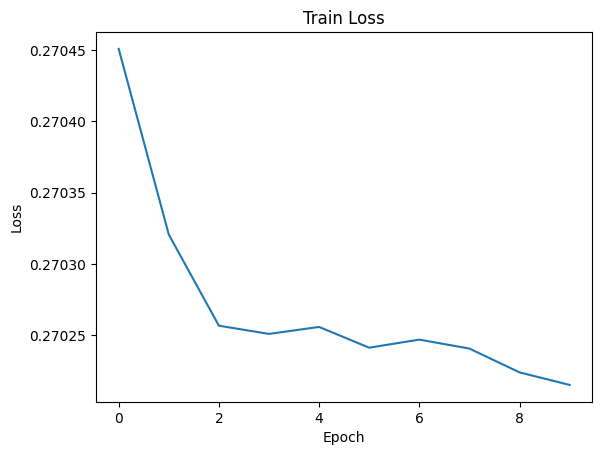

In [20]:
plt.plot(losses)
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

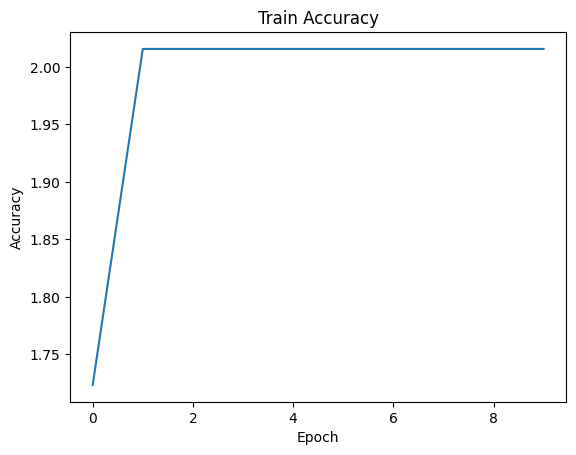

In [21]:
plt.plot(corrects)
plt.title("Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()